#Jin Dai
#SMU Data Science BootCamp
#SQLAlchemy Challenge

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
Data One Year ago:  2016-08-23


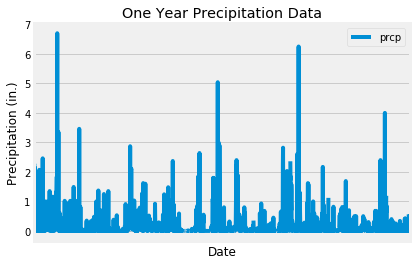

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# use session query to get the latest date
print(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
#calculate the date one year ago from today
year_ago = dt.date(2017,8,23) - relativedelta(months=+12)
print("Data One Year ago: ", year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date > year_ago).order_by(Measurement.date).all()
precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(precipitation, columns=['date','prcp'])
prcp_df = prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_index(ascending=True)
prcp_df.dropna(how='any')
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.xticks([],[] )
plt.xlabel("Date")
plt.ylabel("Precipitation (in.)")

plt.title("One Year Precipitation Data")
plt.show()


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()
summary_temps

[(54.0, 85.0, 71.66378066378067)]

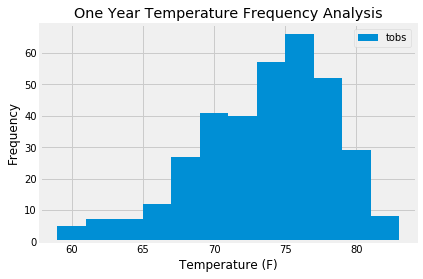

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station=session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.date > year_ago).\
                    filter(Measurement.station==most_active_station).\
                    order_by(Measurement.date).all()
active_station

#plot the results as histogram
temp_df = pd.DataFrame(active_station)
temp_df = temp_df.set_index('date')
temp_df = temp_df.sort_index(ascending=True)
temp_df.plot(kind='hist', bins=12)
plt.title("One Year Temperature Frequency Analysis")
plt.xlabel("Temperature (F)")
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp=calc_temps('2017-02-28', '2017-03-05')
print(trip_temp)

[(64.0, 72.02777777777777, 78.0)]


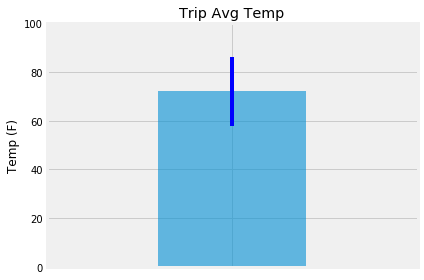

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_temp=trip_temp[0][0]
avg_temp=trip_temp[0][1]
max_temp=trip_temp[0][2]
yerr=max_temp-min_temp

fig, ax = plt.subplots()
ax.bar(1,avg_temp,
       yerr=yerr,
       ecolor='blue',
        alpha=0.6)
ax.set_ylabel('Temp (F)')
ax.set_xticks([1])
ax.set_xticklabels([""])
ax.set_title('Trip Avg Temp')
plt.ylim(0, 100)
plt.xlim(0,2)
plt.tight_layout()
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start='2017-02-28'
trip_end='2017-03-05'
rainfall=session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
            filter(Measurement.station==Station.station).\
            filter(Measurement.date>=trip_start).filter(Measurement.date<=trip_end).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_df=pd.DataFrame(rainfall,columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Total Precipitation (in.)'])
rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Total Precipitation (in.)
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,4.72
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.45
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.07
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.74
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
6,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.16


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip. Using the date of previous year's date
trip_start='2017-02-28'
trip_end='2017-03-05'
# Use the start and end date to create a range of dates
dates_range=session.query(Measurements.date).filter(Measurements.date>=trip_start).\
                filter(Measurements.date<=trip_end)
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

5 days, 0:00:00


In [21]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


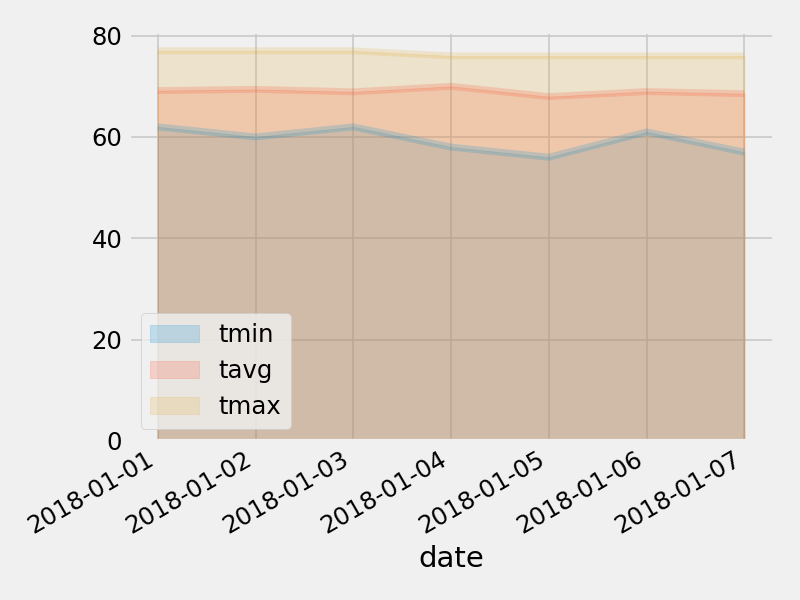

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
